In [1]:
# Step 1: Data Loading and Initial Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Resume.csv to Resume.csv


In [4]:
# Load the dataset
df = pd.read_csv('Resume.csv')

In [5]:
# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (2484, 4)

Column Names:
['ID', 'Resume_str', 'Resume_html', 'Category']

First few rows:
         ID  \
0  16852973   
1  22323967   
2  33176873   
3  27018550   
4  17812897   

                                                                                            Resume_str  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Cu...   
1           HR SPECIALIST, US HR OPERATIONS       Summary     Versatile  media professional with ba...   
2           HR DIRECTOR       Summary      Over 20 years experience in recruiting,   15 plus years ...   
3           HR SPECIALIST       Summary    Dedicated, Driven, and Dynamic with over 20 years of cus...   
4           HR MANAGER         Skill Highlights           HR SKILLS  HR Department Startup  Three N...   

                                                                                           Resume_html  \
0  <div class="fontsize fontface vmargins hmargins linespacin

In [6]:
# Step 2: Data Exploration and Category Analysis

# Explore the target variable (Categories)
print("=== CATEGORY ANALYSIS ===")
print(f"Number of unique categories: {df['Category'].nunique()}")
print(f"\nCategory distribution:")
category_counts = df['Category'].value_counts()
print(category_counts)

=== CATEGORY ANALYSIS ===
Number of unique categories: 24

Category distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


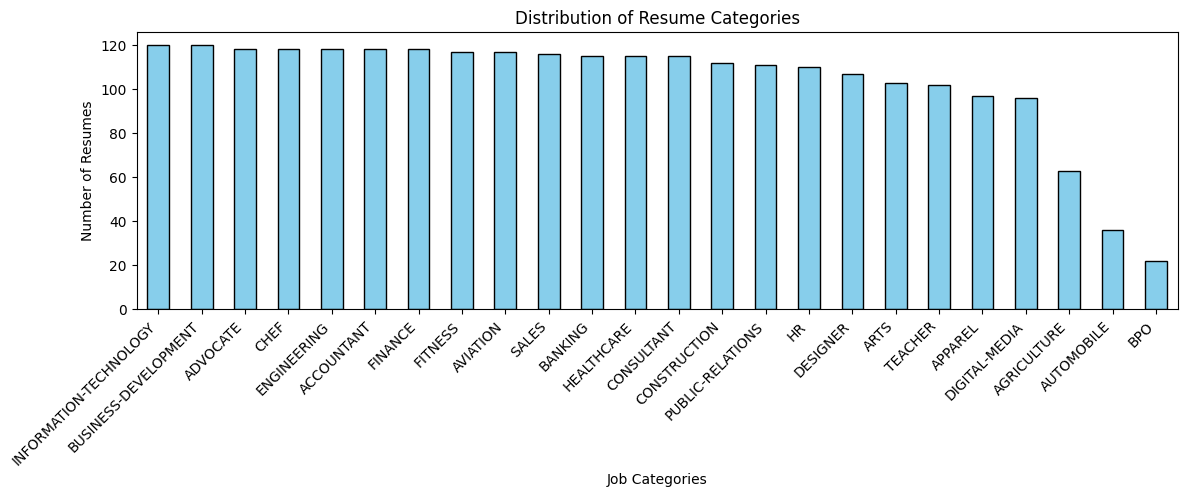

In [7]:
# Visualize category distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Resume Categories')
plt.xlabel('Job Categories')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

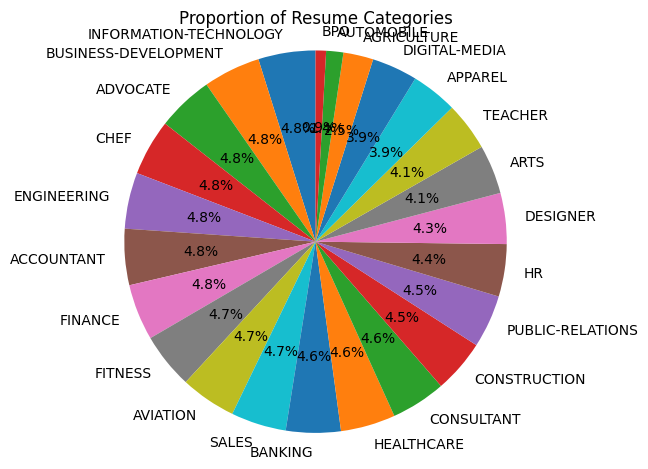

In [8]:
# Pie chart for better proportion view
plt.subplot(1, 1, 1)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Resume Categories')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [9]:
# Text analysis - basic statistics
print("\n=== TEXT ANALYSIS ===")
df['resume_length'] = df['Resume_str'].str.len()
df['word_count'] = df['Resume_str'].str.split().str.len()

print(f"Resume text length statistics:")
print(df['resume_length'].describe())
print(f"\nWord count statistics:")
print(df['word_count'].describe())


=== TEXT ANALYSIS ===
Resume text length statistics:
count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: resume_length, dtype: float64

Word count statistics:
count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: word_count, dtype: float64


In [10]:
# Show sample resume from each category (first occurrence)
print("\n=== SAMPLE RESUMES FROM EACH CATEGORY ===")
for category in df['Category'].unique():
    sample_resume = df[df['Category'] == category]['Resume_str'].iloc[0]
    print(f"\n--- {category} ---")
    print(sample_resume[:300] + "..." if len(sample_resume) > 300 else sample_resume)


=== SAMPLE RESUMES FROM EACH CATEGORY ===

--- HR ---
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commit...

--- DESIGNER ---
         DESIGNER       Summary     Designer with more than 15 years in product design, manufacturing, exhibit design and visual merchandising,  with comprehensive management and logistics experience who thrives in dynamically changing environments. ¬†           Highlights          Design processing ...

--- INFORMATION-TECHNOLOGY ---
         INFORMATION TECHNOLOGY         Summary     Dedicated  Information Assurance Professional ¬†well-versed in analyzing and mitigating risk and finding cost-effective solutions. Excels at boosting performance and productivity by establishing realistic goals and enforcing deadlines

In [11]:
# Step 3: Text Preprocessing and Cleaning
import re
import string
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [12]:
# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if pd.isna(text) or text == '' or len(str(text).strip()) == 0:
        return ""

    text = str(text).lower()

    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers (various formats)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
    text = re.sub(r'\(\d{3}\)\s*\d{3}[-.]?\d{4}', '', text)

    # Remove extra whitespaces, newlines, tabs
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\t+', ' ', text)

    # Remove punctuation except for periods in abbreviations
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers but keep words with numbers (like "3years")
    text = re.sub(r'\b\d+\b', '', text)

    # Remove extra spaces
    text = ' '.join(text.split())

    return text.strip()

def advanced_preprocess(text):
    """
    Advanced preprocessing with tokenization, stopword removal, and lemmatization
    """
    if not text or text == "":
        return ""

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [14]:
# Apply text cleaning
print("Starting text preprocessing...")
print(f"Original data shape: {df.shape}")

Starting text preprocessing...
Original data shape: (2484, 6)


In [15]:
# Check for problematic entries first
print(f"Resumes with 0 words: {(df['word_count'] == 0).sum()}")
print(f"Empty or very short resumes: {(df['resume_length'] < 50).sum()}")

Resumes with 0 words: 1
Empty or very short resumes: 1


In [16]:
# Basic cleaning
df['Resume_cleaned'] = df['Resume_str'].apply(clean_text)

In [17]:
# Advanced preprocessing
df['Resume_processed'] = df['Resume_cleaned'].apply(advanced_preprocess)

In [18]:
# Remove completely empty resumes after processing
initial_count = len(df)
df = df[df['Resume_processed'].str.len() > 0].reset_index(drop=True)
final_count = len(df)

print(f"Removed {initial_count - final_count} empty resumes after preprocessing")
print(f"Final dataset shape: {df.shape}")

Removed 1 empty resumes after preprocessing
Final dataset shape: (2483, 8)


In [19]:
# Update text statistics after cleaning
df['processed_length'] = df['Resume_processed'].str.len()
df['processed_word_count'] = df['Resume_processed'].str.split().str.len()

print("\n=== PROCESSED TEXT STATISTICS ===")
print("Character length after processing:")
print(df['processed_length'].describe())
print("\nWord count after processing:")
print(df['processed_word_count'].describe())


=== PROCESSED TEXT STATISTICS ===
Character length after processing:
count     2483.000000
mean      4797.954491
std       2142.686705
min        529.000000
25%       3907.000000
50%       4485.000000
75%       5549.000000
max      27396.000000
Name: processed_length, dtype: float64

Word count after processing:
count    2483.000000
mean      584.976641
std       260.738643
min        74.000000
25%       477.000000
50%       547.000000
75%       674.500000
max      3543.000000
Name: processed_word_count, dtype: float64


In [20]:
# Show before/after comparison for a sample
print("\n=== BEFORE/AFTER COMPARISON (First HR Resume) ===")
sample_idx = 0
print("ORIGINAL:")
print(df['Resume_str'].iloc[sample_idx][:500] + "...")
print("\nCLEANED:")
print(df['Resume_cleaned'].iloc[sample_idx][:500] + "...")
print("\nPROCESSED:")
print(df['Resume_processed'].iloc[sample_idx][:500] + "...")


=== BEFORE/AFTER COMPARISON (First HR Resume) ===
ORIGINAL:
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-task...

CLEANED:
hr administrator marketing associate hr administrator summary dedicated customer service manager with years of experience in hospitality and customer service management respected builder and leader of customer focused teams strives to instill a shared enthusiastic commitment to customer service highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and developme

In [21]:
# Step 4: Feature Engineering - TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

In [23]:
# Show the encoding mapping
print("=== CATEGORY ENCODING ===")
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
for category, code in sorted(category_mapping.items()):
    print(f"{category}: {code}")

print(f"\nTotal categories: {len(label_encoder.classes_)}")

=== CATEGORY ENCODING ===
ACCOUNTANT: 0
ADVOCATE: 1
AGRICULTURE: 2
APPAREL: 3
ARTS: 4
AUTOMOBILE: 5
AVIATION: 6
BANKING: 7
BPO: 8
BUSINESS-DEVELOPMENT: 9
CHEF: 10
CONSTRUCTION: 11
CONSULTANT: 12
DESIGNER: 13
DIGITAL-MEDIA: 14
ENGINEERING: 15
FINANCE: 16
FITNESS: 17
HEALTHCARE: 18
HR: 19
INFORMATION-TECHNOLOGY: 20
PUBLIC-RELATIONS: 21
SALES: 22
TEACHER: 23

Total categories: 24


In [24]:
# Prepare features and target
X = df['Resume_processed']
y = df['Category_encoded']

print(f"\nFeature vector shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature vector shape: (2483,)
Target vector shape: (2483,)


In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Train set size: 1986
Test set size: 497


In [26]:
# Check class distribution in train/test
print("\n=== CLASS DISTRIBUTION ===")
print("Training set distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist):
    category_name = label_encoder.inverse_transform([i])[0]
    print(f"{category_name}: {count}")


=== CLASS DISTRIBUTION ===
Training set distribution:
ACCOUNTANT: 94
ADVOCATE: 94
AGRICULTURE: 50
APPAREL: 78
ARTS: 82
AUTOMOBILE: 29
AVIATION: 93
BANKING: 92
BPO: 18
BUSINESS-DEVELOPMENT: 95
CHEF: 94
CONSTRUCTION: 90
CONSULTANT: 92
DESIGNER: 86
DIGITAL-MEDIA: 77
ENGINEERING: 94
FINANCE: 94
FITNESS: 94
HEALTHCARE: 92
HR: 88
INFORMATION-TECHNOLOGY: 96
PUBLIC-RELATIONS: 89
SALES: 93
TEACHER: 82


In [27]:
# TF-IDF Vectorization
print("\n=== TF-IDF VECTORIZATION ===")

# Initialize TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features to manage dimensionality
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.95,        # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2), # Use unigrams and bigrams
    stop_words='english', # Additional stopword removal
    sublinear_tf=True   # Apply sublinear scaling to tf
)


=== TF-IDF VECTORIZATION ===


In [28]:
# Fit on training data and transform both train and test
print("Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Fitting TF-IDF vectorizer on training data...


In [29]:
print(f"TF-IDF feature matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF feature matrix shape (test): {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF feature matrix shape (train): (1986, 5000)
TF-IDF feature matrix shape (test): (497, 5000)
Vocabulary size: 5000


In [30]:
# Show some feature statistics
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nFirst 20 features: {list(feature_names[:20])}")
print(f"Last 20 features: {list(feature_names[-20:])}")


First 20 features: ['11g', '1st', '2nd', '3rd', 'abc', 'ability', 'ability manage', 'ability work', 'able', 'able work', 'abreast', 'abroad', 'absence', 'abuse', 'academic', 'academic achievement', 'academy', 'acceptance', 'accepted', 'access']
Last 20 features: ['written communication', 'written oral', 'written verbal', 'wrote', 'xml', 'year', 'year end', 'year experience', 'year old', 'year sale', 'year year', 'yearly', 'yoga', 'york', 'york city', 'young', 'youth', 'yr', 'zero', 'zone']


In [31]:
# Check sparsity
sparsity_train = 1.0 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))
sparsity_test = 1.0 - (X_test_tfidf.nnz / (X_test_tfidf.shape[0] * X_test_tfidf.shape[1]))
print(f"\nTF-IDF matrix sparsity (train): {sparsity_train:.4f}")
print(f"TF-IDF matrix sparsity (test): {sparsity_test:.4f}")


TF-IDF matrix sparsity (train): 0.9410
TF-IDF matrix sparsity (test): 0.9407


In [32]:
# Show most important features (highest average TF-IDF scores)
print("\n=== TOP FEATURES BY AVERAGE TF-IDF SCORE ===")
mean_tfidf_scores = np.array(X_train_tfidf.mean(axis=0)).flatten()
top_features_idx = mean_tfidf_scores.argsort()[-20:][::-1]

for i, idx in enumerate(top_features_idx):
    feature_name = feature_names[idx]
    score = mean_tfidf_scores[idx]
    print(f"{i+1:2d}. {feature_name:20s}: {score:.6f}")

print("\n=== DATA PREPARATION COMPLETE ===")
print("‚úì Text preprocessing completed")
print("‚úì Labels encoded")
print("‚úì Train-test split completed")
print("‚úì TF-IDF vectorization completed")
print("‚úì Ready for model training!")


=== TOP FEATURES BY AVERAGE TF-IDF SCORE ===
 1. company city        : 0.030357
 2. management          : 0.029010
 3. customer            : 0.028975
 4. service             : 0.026633
 5. sale                : 0.026210
 6. business            : 0.024762
 7. client              : 0.023657
 8. team                : 0.023556
 9. project             : 0.023406
10. new                 : 0.022858
11. manager             : 0.022085
12. training            : 0.021648
13. development         : 0.021589
14. work                : 0.021000
15. office              : 0.020582
16. process             : 0.020524
17. program             : 0.020461
18. product             : 0.020181
19. information         : 0.019841
20. professional        : 0.019290

=== DATA PREPARATION COMPLETE ===
‚úì Text preprocessing completed
‚úì Labels encoded
‚úì Train-test split completed
‚úì TF-IDF vectorization completed
‚úì Ready for model training!


In [33]:
# Step 5: Model Training and Evaluation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import time

In [34]:
# Dictionary to store models and their performance
models = {}
results = {}

In [35]:
print("=== MODEL TRAINING AND EVALUATION ===")

# 1. Multinomial Naive Bayes (Great for text classification)
print("\n1. Training Multinomial Naive Bayes...")
start_time = time.time()

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_train_time = time.time() - start_time

nb_accuracy = accuracy_score(y_test, nb_pred)
models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {
    'predictions': nb_pred,
    'accuracy': nb_accuracy,
    'train_time': nb_train_time
}

print(f"   Accuracy: {nb_accuracy:.4f}")
print(f"   Training time: {nb_train_time:.2f} seconds")

=== MODEL TRAINING AND EVALUATION ===

1. Training Multinomial Naive Bayes...
   Accuracy: 0.5513
   Training time: 0.02 seconds


In [36]:
# 2. Logistic Regression (Linear model, good baseline)
print("\n2. Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr',  # One-vs-Rest for multi-class
    solver='liblinear'   # Good for small datasets
)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_train_time = time.time() - start_time

lr_accuracy = accuracy_score(y_test, lr_pred)
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'predictions': lr_pred,
    'accuracy': lr_accuracy,
    'train_time': lr_train_time
}

print(f"   Accuracy: {lr_accuracy:.4f}")
print(f"   Training time: {lr_train_time:.2f} seconds")


2. Training Logistic Regression...
   Accuracy: 0.6419
   Training time: 0.84 seconds


In [37]:
# 3. Random Forest (Ensemble method)
print("\n3. Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_train_time = time.time() - start_time

rf_accuracy = accuracy_score(y_test, rf_pred)
models['Random Forest'] = rf_model
results['Random Forest'] = {
    'predictions': rf_pred,
    'accuracy': rf_accuracy,
    'train_time': rf_train_time
}

print(f"   Accuracy: {rf_accuracy:.4f}")
print(f"   Training time: {rf_train_time:.2f} seconds")


3. Training Random Forest...
   Accuracy: 0.7586
   Training time: 3.64 seconds


In [38]:
# 4. Support Vector Machine (Powerful for high-dimensional data)
print("\n4. Training Support Vector Machine...")
start_time = time.time()

svm_model = SVC(
    kernel='linear',  # Linear kernel works well with TF-IDF
    random_state=42,
    C=1.0
)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_train_time = time.time() - start_time

svm_accuracy = accuracy_score(y_test, svm_pred)
models['SVM'] = svm_model
results['SVM'] = {
    'predictions': svm_pred,
    'accuracy': svm_accuracy,
    'train_time': svm_train_time
}

print(f"   Accuracy: {svm_accuracy:.4f}")
print(f"   Training time: {svm_train_time:.2f} seconds")


4. Training Support Vector Machine...
   Accuracy: 0.6740
   Training time: 16.11 seconds


In [39]:
# Compare all models
print("\n=== MODEL COMPARISON ===")
print(f"{'Model':<20} {'Accuracy':<12} {'Training Time':<15}")
print("-" * 50)
for model_name, result in results.items():
    print(f"{model_name:<20} {result['accuracy']:<12.4f} {result['train_time']:<15.2f}s")


=== MODEL COMPARISON ===
Model                Accuracy     Training Time  
--------------------------------------------------
Naive Bayes          0.5513       0.02           s
Logistic Regression  0.6419       0.84           s
Random Forest        0.7586       3.64           s
SVM                  0.6740       16.11          s


In [40]:
# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
best_predictions = results[best_model_name]['predictions']

print(f"\nüèÜ Best Model: {best_model_name} (Accuracy: {results[best_model_name]['accuracy']:.4f})")


üèÜ Best Model: Random Forest (Accuracy: 0.7586)


In [41]:
# Detailed evaluation of best model
print(f"\n=== DETAILED EVALUATION - {best_model_name.upper()} ===")

# Classification report
target_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=target_names, zero_division=0))


=== DETAILED EVALUATION - RANDOM FOREST ===

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.72      0.96      0.82        24
              ADVOCATE       0.86      0.79      0.83        24
           AGRICULTURE       1.00      0.46      0.63        13
               APPAREL       1.00      0.47      0.64        19
                  ARTS       0.67      0.19      0.30        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.85      0.92      0.88        24
               BANKING       0.71      0.52      0.60        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.86      1.00      0.92        24
                  CHEF       0.86      0.75      0.80        24
          CONSTRUCTION       0.83      0.91      0.87        22
            CONSULTANT       0.76      0.57      0.65        23
              DESIGNER       0.80 

In [42]:
# Overall metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, best_predictions, average='weighted')
print(f"\nWeighted Average Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\n=== MODEL TRAINING COMPLETE ===")
print(f"‚úì {len(models)} models trained and evaluated")
print(f"‚úì Best performing model: {best_model_name}")
print(f"‚úì Ready for confusion matrix analysis!")


Weighted Average Metrics:
Precision: 0.7584
Recall: 0.7586
F1-Score: 0.7367

=== MODEL TRAINING COMPLETE ===
‚úì 4 models trained and evaluated
‚úì Best performing model: Random Forest
‚úì Ready for confusion matrix analysis!


In [43]:
# Step 6: Confusion Matrix and Feature Importance Analysis
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
print("=== CONFUSION MATRIX ANALYSIS ===")

# Create confusion matrix
cm = confusion_matrix(y_test, best_predictions)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

=== CONFUSION MATRIX ANALYSIS ===


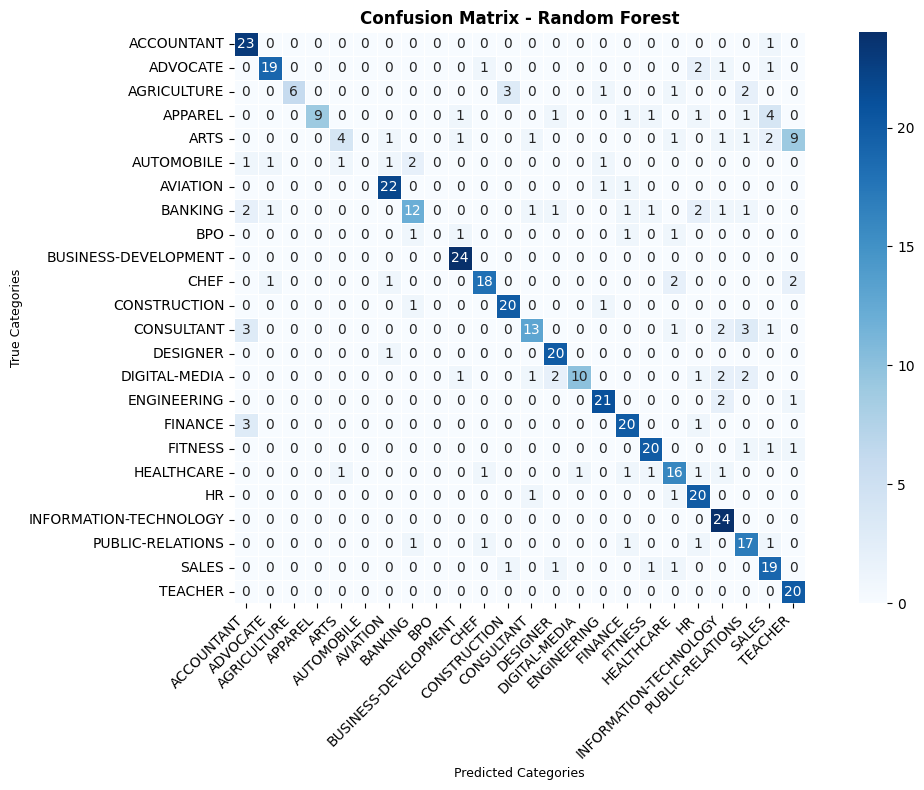

In [45]:
# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            square=True, linewidths=0.5)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Categories', fontsize=9)
plt.ylabel('True Categories', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
# Analyze misclassifications
print("\n=== MISCLASSIFICATION ANALYSIS ===")
misclassified_pairs = []

for i in range(len(target_names)):
    for j in range(len(target_names)):
        if i != j and cm[i][j] > 0:  # Misclassified cases
            true_label = target_names[i]
            pred_label = target_names[j]
            count = cm[i][j]
            misclassified_pairs.append((true_label, pred_label, count))

# Sort by count of misclassifications
misclassified_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 10 Most Common Misclassifications:")
print(f"{'True Category':<20} {'Predicted As':<20} {'Count':<6}")
print("-" * 50)
for true_cat, pred_cat, count in misclassified_pairs[:10]:
    print(f"{true_cat:<20} {pred_cat:<20} {count:<6}")


=== MISCLASSIFICATION ANALYSIS ===
Top 10 Most Common Misclassifications:
True Category        Predicted As         Count 
--------------------------------------------------
ARTS                 TEACHER              9     
APPAREL              SALES                4     
AGRICULTURE          CONSTRUCTION         3     
CONSULTANT           ACCOUNTANT           3     
CONSULTANT           PUBLIC-RELATIONS     3     
FINANCE              ACCOUNTANT           3     
ADVOCATE             HR                   2     
AGRICULTURE          PUBLIC-RELATIONS     2     
ARTS                 SALES                2     
AUTOMOBILE           BANKING              2     



=== FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST ===
Top 20 Most Important Features:
Rank Feature                   Importance  
---------------------------------------------
1    construction              0.009412    
2    fitness                   0.008913    
3    business development      0.008243    
4    advocate                  0.008108    
5    designer                  0.007906    
6    healthcare                0.007504    
7    information technology    0.007404    
8    aviation                  0.007057    
9    engineering               0.006970    
10   accountant                0.006383    
11   aircraft                  0.006174    
12   chef                      0.006080    
13   finance                   0.005980    
14   public relation           0.005644    
15   sale                      0.005542    
16   consultant                0.005384    
17   teacher                   0.005215    
18   experience sale           0.004700    
19   banking                   0.

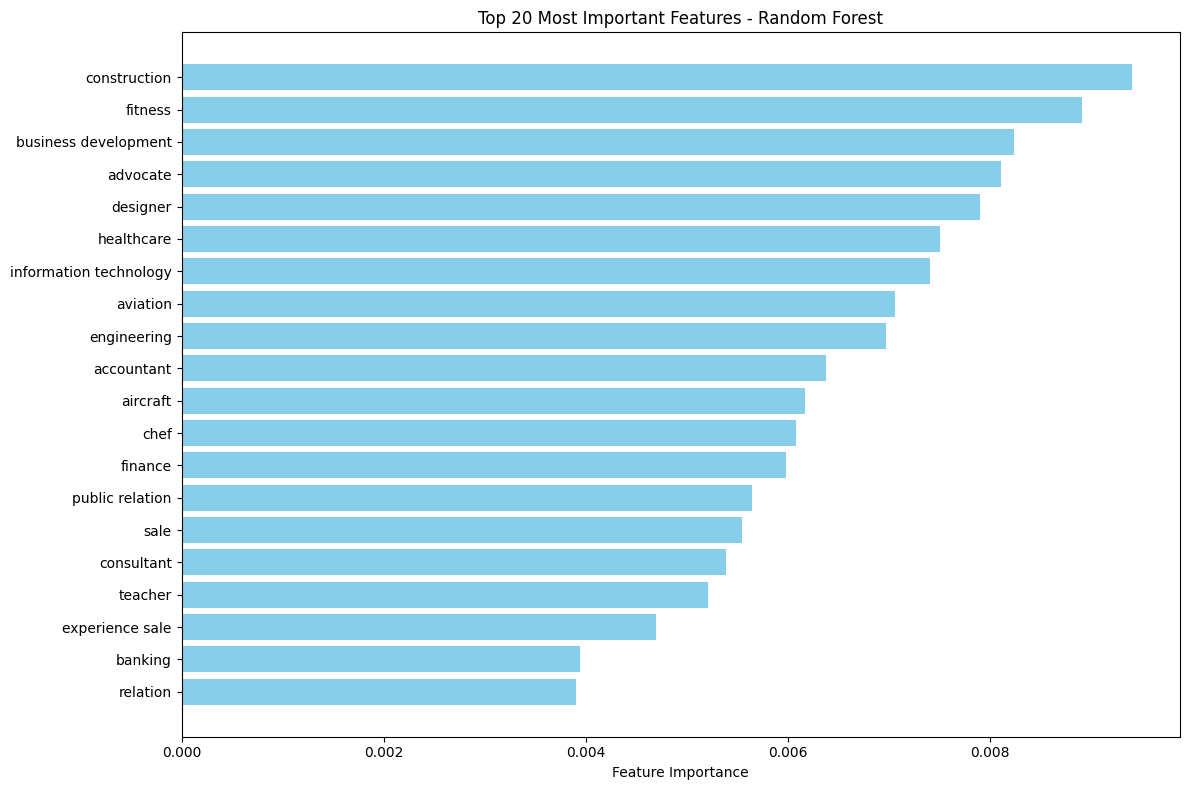


Feature Importance Statistics:
Mean importance: 0.000200
Std importance: 0.000515
Max importance: 0.009412
Min importance: 0.000000
Features with importance > 0.001: 143


In [47]:
# Feature Importance Analysis (Random Forest specific)
if best_model_name == 'Random Forest':
    print(f"\n=== FEATURE IMPORTANCE ANALYSIS - {best_model_name.upper()} ===")

    # Get feature importance
    feature_importance = best_model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    # Top 20 most important features
    top_features = importance_df.head(20)
    print("Top 20 Most Important Features:")
    print(f"{'Rank':<4} {'Feature':<25} {'Importance':<12}")
    print("-" * 45)
    for idx, row in top_features.iterrows():
        rank = top_features.index.get_loc(idx) + 1
        print(f"{rank:<4} {row['feature']:<25} {row['importance']:<12.6f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Show feature importance statistics
    print(f"\nFeature Importance Statistics:")
    print(f"Mean importance: {feature_importance.mean():.6f}")
    print(f"Std importance: {feature_importance.std():.6f}")
    print(f"Max importance: {feature_importance.max():.6f}")
    print(f"Min importance: {feature_importance.min():.6f}")
    print(f"Features with importance > 0.001: {(feature_importance > 0.001).sum()}")

In [48]:
# Model Performance Summary
print(f"\n=== MODEL PERFORMANCE SUMMARY ===")
print(f"Best Model: {best_model_name}")
print(f"Overall Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Training Time: {results[best_model_name]['train_time']:.2f} seconds")
print(f"Total Categories: {len(target_names)}")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correctly Classified: {(best_predictions == y_test).sum()}")
print(f"Misclassified: {(best_predictions != y_test).sum()}")


=== MODEL PERFORMANCE SUMMARY ===
Best Model: Random Forest
Overall Accuracy: 0.7586
Training Time: 3.64 seconds
Total Categories: 24
Total Test Samples: 497
Correctly Classified: 377
Misclassified: 120


In [49]:
# Category-wise accuracy
print(f"\n=== CATEGORY-WISE ACCURACY ===")
category_accuracy = []
for i, category in enumerate(target_names):
    category_mask = (y_test == i)
    if category_mask.sum() > 0:  # Only if category exists in test set
        category_pred = best_predictions[category_mask]
        category_true = y_test[category_mask]
        accuracy = (category_pred == category_true).mean()
        support = category_mask.sum()
        category_accuracy.append((category, accuracy, support))

category_accuracy.sort(key=lambda x: x[1], reverse=True)

print(f"{'Category':<25} {'Accuracy':<10} {'Support':<8}")
print("-" * 45)
for category, accuracy, support in category_accuracy:
    print(f"{category:<25} {accuracy:<10.3f} {support:<8}")

print(f"\n‚úì Confusion matrix analysis completed")
print(f"‚úì Feature importance analysis completed")
print(f"‚úì Ready for model optimization or deployment!")


=== CATEGORY-WISE ACCURACY ===
Category                  Accuracy   Support 
---------------------------------------------
BUSINESS-DEVELOPMENT      1.000      24      
INFORMATION-TECHNOLOGY    1.000      24      
TEACHER                   1.000      20      
ACCOUNTANT                0.958      24      
DESIGNER                  0.952      21      
AVIATION                  0.917      24      
CONSTRUCTION              0.909      22      
HR                        0.909      22      
ENGINEERING               0.875      24      
FITNESS                   0.870      23      
FINANCE                   0.833      24      
SALES                     0.826      23      
ADVOCATE                  0.792      24      
PUBLIC-RELATIONS          0.773      22      
CHEF                      0.750      24      
HEALTHCARE                0.696      23      
CONSULTANT                0.565      23      
DIGITAL-MEDIA             0.526      19      
BANKING                   0.522      23      
AP

In [50]:
# Step 7: Model Deployment Preparation
import pickle
import joblib
from datetime import datetime
import json

In [65]:
print("=== MODEL DEPLOYMENT PREPARATION ===")

# Create deployment package with explicit type conversion
deployment_package = {
    'model': best_model,
    'vectorizer': tfidf_vectorizer,
    'label_encoder': label_encoder,
    'feature_names': feature_names,
    'model_name': str(best_model_name),
    'performance_metrics': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'training_time': float(results[best_model_name]['train_time']),
        'total_categories': int(len(target_names)),
        'feature_count': int(len(feature_names))
    },
    'training_info': {
        'training_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'tfidf_params': {
            'max_features': 5000,
            'min_df': 2,
            'max_df': 0.95,
            'ngram_range': (1, 2)
        }
    }
}

=== MODEL DEPLOYMENT PREPARATION ===


In [52]:
# Save the complete model pipeline
print("1. Saving model pipeline...")
joblib.dump(deployment_package, 'resume_screener_model.pkl')
print("   ‚úì Model saved as 'resume_screener_model.pkl'")

1. Saving model pipeline...
   ‚úì Model saved as 'resume_screener_model.pkl'


In [53]:
# Verify the model loads correctly
try:
    test_load = joblib.load('resume_screener_model.pkl')
    print("   ‚úì Model verification successful")
except Exception as e:
    print(f"   ‚úó Model verification failed: {e}")

   ‚úì Model verification successful


In [66]:
# Create prediction function with FIXED regex patterns
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
def ensure_nltk_data():
    """Download NLTK data if not present"""
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')

# Initialize preprocessing tools
ensure_nltk_data()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Clean resume text - FIXED regex patterns"""
    if pd.isna(text) or text == '' or len(str(text).strip()) == 0:
        return ""

    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\\S+@\\S+', '', text)  # Remove emails
    text = re.sub(r'\\b\\d{3}[-.]?\\d{3}[-.]?\\d{4}\\b', '', text)  # Remove phone numbers
    text = re.sub(r'\\(\\d{3}\\)\\s*\\d{3}[-.]?\\d{4}', '', text)  # Remove phone numbers
    text = re.sub(r'\\s+', ' ', text)  # Multiple spaces to single
    text = re.sub(r'\\n+', ' ', text)  # Newlines to spaces
    text = re.sub(r'\\t+', ' ', text)  # Tabs to spaces
    text = re.sub(r'[^\\w\\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\\b\\d+\\b', '', text)  # Remove standalone numbers
    text = ' '.join(text.split())  # Clean extra whitespace
    return text.strip()

def advanced_preprocess(text):
    """Advanced preprocessing with tokenization and lemmatization"""
    if not text or text == "":
        return ""

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

def predict_resume_category(resume_text, model_path='resume_screener_model.pkl'):
    """Predict job category for resume text"""
    # Load model package
    model_package = joblib.load(model_path)

    model = model_package['model']
    vectorizer = model_package['vectorizer']
    label_encoder = model_package['label_encoder']

    # Preprocess using same pipeline as training
    cleaned_text = clean_text(resume_text)
    processed_text = advanced_preprocess(cleaned_text)

    # Vectorize and predict
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)[0]
    prediction_proba = model.predict_proba(text_vector)[0]

    # Format results
    predicted_category = label_encoder.inverse_transform([prediction])[0]
    confidence = prediction_proba[prediction]

    top_3_indices = prediction_proba.argsort()[-3:][::-1]
    top_3_categories = label_encoder.inverse_transform(top_3_indices)
    top_3_probabilities = prediction_proba[top_3_indices]

    return {
        'predicted_category': predicted_category,
        'confidence': float(confidence),
        'top_3_predictions': [
            {'category': cat, 'probability': float(prob)}
            for cat, prob in zip(top_3_categories, top_3_probabilities)
        ]
    }

if __name__ == "__main__":
    # Example usage
    sample_resume = "Software engineer with 5 years experience in Python, machine learning, and data science..."
    result = predict_resume_category(sample_resume)
    print("Prediction:", result)

Prediction: {'predicted_category': 'ARTS', 'confidence': 0.14, 'top_3_predictions': [{'category': 'ARTS', 'probability': 0.14}, {'category': 'AVIATION', 'probability': 0.11}, {'category': 'CONSTRUCTION', 'probability': 0.09}]}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:
# Save the prediction module
print("2. Creating prediction module...")
with open('resume_predictor.py', 'w') as f:
    f.write(prediction_code)
print("   ‚úì Prediction module saved as 'resume_predictor.py'")

2. Creating prediction module...
   ‚úì Prediction module saved as 'resume_predictor.py'


In [68]:
# Test the prediction function with a sample
print("3. Testing prediction function...")
sample_resume = """
INFORMATION TECHNOLOGY SPECIALIST

Summary: Experienced software engineer with 5+ years in Python development,
machine learning, and data analysis. Skilled in building scalable applications
and working with databases. Strong background in artificial intelligence and
neural networks.

Experience:
- Software Developer at Tech Company
- Built machine learning models
- Developed web applications using Django
- Database optimization and management
"""

3. Testing prediction function...


In [69]:
# Create a test function that works with the deployment_package directly
def test_prediction_with_package(resume_text, model_package):
    """Test prediction function using deployment package directly"""
    model = model_package['model']
    vectorizer = model_package['vectorizer']
    label_encoder = model_package['label_encoder']

    # Preprocess using same pipeline as training
    cleaned_text = clean_text(resume_text)
    processed_text = advanced_preprocess(cleaned_text)

    # Vectorize and predict
    text_vector = vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)[0]
    prediction_proba = model.predict_proba(text_vector)[0]

    # Format results
    predicted_category = label_encoder.inverse_transform([prediction])[0]
    confidence = prediction_proba[prediction]

    top_3_indices = prediction_proba.argsort()[-3:][::-1]
    top_3_categories = label_encoder.inverse_transform(top_3_indices)
    top_3_probabilities = prediction_proba[top_3_indices]

    return {
        'predicted_category': predicted_category,
        'confidence': float(confidence),
        'top_3_predictions': [
            {'category': cat, 'probability': float(prob)}
            for cat, prob in zip(top_3_categories, top_3_probabilities)
        ]
    }

In [70]:
# Test with the in-memory deployment package
prediction_result = test_prediction_with_package(sample_resume, deployment_package)
print("   Sample Resume Prediction:")
print(f"   Predicted Category: {prediction_result['predicted_category']}")
print(f"   Confidence: {prediction_result['confidence']:.4f}")
print("   Top 3 Predictions:")
for i, pred in enumerate(prediction_result['top_3_predictions'], 1):
    print(f"   {i}. {pred['category']}: {pred['probability']:.4f}")

   Sample Resume Prediction:
   Predicted Category: ARTS
   Confidence: 0.1400
   Top 3 Predictions:
   1. ARTS: 0.1400
   2. AVIATION: 0.1100
   3. CONSTRUCTION: 0.0900


In [71]:
# Also test loading from the saved file
print("\n   Testing saved model file...")
try:
    loaded_package = joblib.load('resume_screener_model.pkl')
    test_result = test_prediction_with_package(sample_resume, loaded_package)
    print(f"   ‚úì File-based prediction successful: {test_result['predicted_category']}")
except Exception as e:
    print(f"   ‚úó File-based prediction failed: {e}")


   Testing saved model file...
   ‚úì File-based prediction successful: ARTS


In [72]:
# Create model documentation
documentation = {
    "model_info": {
        "name": "AI-Powered Resume Screener",
        "algorithm": str(best_model_name),
        "version": "1.0",
        "created_date": datetime.now().strftime("%Y-%m-%d")
    },
    "performance": {
        "overall_accuracy": float(results[best_model_name]['accuracy']),
        "total_categories": int(len(target_names)),
        "training_samples": int(len(X_train)),
        "test_samples": int(len(X_test))
    },
    "categories": target_names.tolist(),
    "usage_instructions": {
        "1": "Load model: model_package = joblib.load('resume_screener_model.pkl')",
        "2": "Predict: result = predict_resume_category(resume_text, model_package)",
        "3": "Access prediction: result['predicted_category']",
        "4": "Access confidence: result['confidence']"
    },
    "preprocessing_steps": [
        "Text cleaning (remove HTML, URLs, emails, phone numbers)",
        "Lowercase conversion",
        "Punctuation removal",
        "Tokenization",
        "Stop word removal",
        "Lemmatization",
        "TF-IDF vectorization (max_features=5000, ngram_range=(1,2))"
    ]
}

In [73]:
# Save documentation
print("4. Creating model documentation...")
with open('model_documentation.json', 'w') as f:
    json.dump(documentation, f, indent=2)
print("   ‚úì Documentation saved as 'model_documentation.json'")

print(f"\n=== DEPLOYMENT PACKAGE READY ===")
print("Files created for deployment:")
print("‚úì resume_screener_model.pkl - Complete trained model pipeline")
print("‚úì resume_predictor.py - Standalone prediction module")
print("‚úì model_documentation.json - Model information and usage guide")
print(f"\nModel Performance Summary:")
print(f"‚Ä¢ Algorithm: {best_model_name}")
print(f"‚Ä¢ Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"‚Ä¢ Categories: {len(target_names)}")
print(f"‚Ä¢ Features: {len(feature_names)}")
print(f"‚Ä¢ Ready for production deployment!")

4. Creating model documentation...
   ‚úì Documentation saved as 'model_documentation.json'

=== DEPLOYMENT PACKAGE READY ===
Files created for deployment:
‚úì resume_screener_model.pkl - Complete trained model pipeline
‚úì resume_predictor.py - Standalone prediction module
‚úì model_documentation.json - Model information and usage guide

Model Performance Summary:
‚Ä¢ Algorithm: Random Forest
‚Ä¢ Accuracy: 0.7586
‚Ä¢ Categories: 24
‚Ä¢ Features: 5000
‚Ä¢ Ready for production deployment!
